In [703]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [704]:
def import_24bit_data(fn):
    table = pd.read_csv(fn, sep=',', skiprows = 0)
    table.columns = np.arange(0,422,1)
    
    data_ch0 = []
    for i in range(len(table[0])):
        for j in range(60):
            data_ch0.append(table[j][i])
            
    data_ch1 = []
    for i in range(len(table[60])):
        for j in range(60):
            data_ch1.append(table[60 + j][i])
            
    data_ch2 = []
    for i in range(len(table[120])):
        for j in range(60):
            data_ch2.append(table[120 +j][i])
            
    clock_ticks = []
    for i in range(len(table[360])):
        for j in range(60):
            clock_ticks.append(table[360+j][i])
    
    data_ch0 = np.array(data_ch0)
    data_ch1 = np.array(data_ch1)
    data_ch2 = np.array(data_ch2)
    clock_ticks = np.array(clock_ticks)
    times_1 = np.array(table[420])
    times_2 = np.array(table[421])

    clock_float = clock_ticks.astype(float)

    clock_ticks_diff = []
    for i in range(len(clock_ticks) - 1):
        diff = clock_float[i+1] - clock_float[i]
        if diff > 0:
            clock_ticks_diff.append(diff)

    clock_rate = 10**6
    
    #clock_ticks_diff = [clock_float[i+1] - clock_float[i] for i in range(len(clock_ticks)-1)]
    print("NUMBER OF DATA POINTS:", len(data_ch1))
    print("MEAN CLOCK TICK DIFF:", np.mean(clock_ticks_diff))
    print("MEAN PERIOD:", np.mean(clock_ticks_diff)/(clock_rate))
    print("MEAN FREQ (Hz):", 1/(np.mean(clock_ticks_diff)/(clock_rate)))
        
    return data_ch0, data_ch1, data_ch2, clock_ticks, times_1, times_2, 1/(np.mean(clock_ticks_diff)/clock_rate)

In [705]:
fn = r"C:\Users\natal\Accelerometer_data\20250718T134259_cgem_accel\20250718T134259_FILE0001_cgem_accel.csv" #replace file path
data_ch0, data_ch1, data_ch2, clock_ticks, times1, times2, mean_freq = import_24bit_data(fn)

NUMBER OF DATA POINTS: 16440
MEAN CLOCK TICK DIFF: 1225.8611753254654
MEAN PERIOD: 0.0012258611753254655
MEAN FREQ (Hz): 815.7530559971447


In [708]:
voltage = lambda raw: 1.78*(raw / (16777215))
# bottom is -4g
# top is 4g

def accel(raw_ch):
     # a = (V - (V_ref / 2)) / 0.2
    a = (raw_ch / 16777215)*9 - 4.5
    #a = ((raw_ch / 16777215) - 0.5) / 0.2
    return a

In [709]:
print("Voltage (V):")
print("(approx) channel 0 average voltage:", voltage(np.mean(data_ch0)))
print("(approx) channel 1 average voltage:", voltage(np.mean(data_ch1)))
print("(approx) channel 2 average voltage:", voltage(np.mean(data_ch2)))
print("")
print("Acceleration (g):")
print("channel 0 average accel:", accel(np.mean(data_ch0)))
print("channel 1 average accel:", accel(np.mean(data_ch1)))
print("channel 2 average accel:", accel(np.mean(data_ch2)))

total_accel = np.sqrt((accel(np.mean(data_ch0))**2 + accel(np.mean(data_ch1))**2 + accel(np.mean(data_ch2))**2))
print("total magnitude of acceleration:", total_accel)

Voltage (V):
(approx) channel 0 average voltage: 0.8870020418506961
(approx) channel 1 average voltage: 0.8909023956504014
(approx) channel 2 average voltage: 1.0854027543566134

Acceleration (g):
channel 0 average accel: -0.015158215361648963
channel 1 average accel: 0.004562674636860997
channel 2 average accel: 0.9879914546120903
total magnitude of acceleration: 0.9881182641158426


C:\Users\natal\AppData\Local\Temp\ipykernel_22024\391398852.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


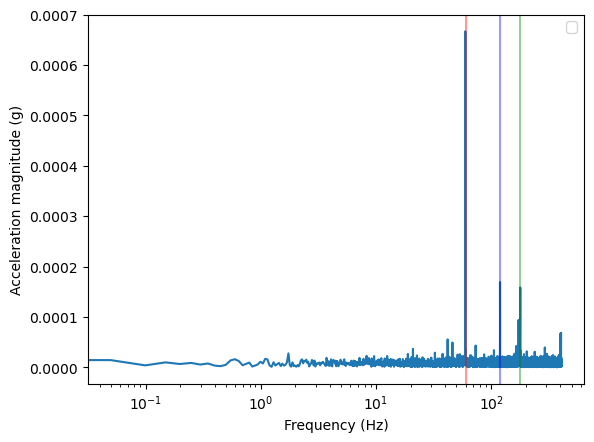

C:\Users\natal\AppData\Local\Temp\ipykernel_22024\391398852.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


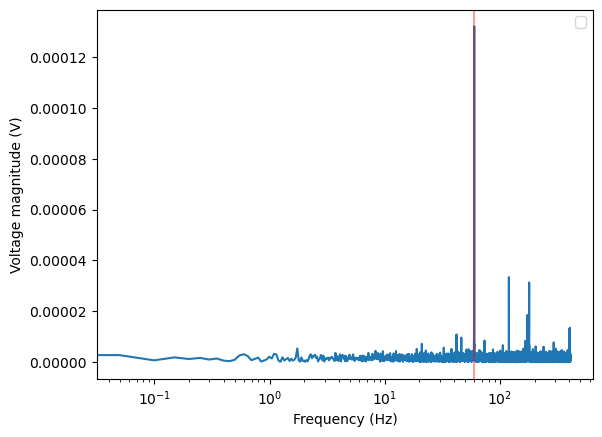

In [710]:
data_ch = data_ch2 #set to any data channel
sampling_rate = 817
N = len(data_ch)
s = np.fft.fft(accel(data_ch) - accel(data_ch.mean())) 
freqs = np.fft.fftfreq(len(data_ch), d=1/sampling_rate)

positive_freqs = freqs[:len(data_ch) // 2]
A_fft = np.abs(s[:len(data_ch) // 2])

# determine the amplitude of the signal in acceleration (g)
A_signal_g = A_fft / (N / 2)

# Plot frequencies
plt.plot(positive_freqs, A_signal_g)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Acceleration magnitude (g)")
plt.xscale('log')
#plt.yscale('log')

plt.axvline(60, c='red', label='60Hz', alpha=0.4)
plt.axvline(120, c='blue', label='120Hz', alpha=0.4)
plt.axvline(180, c='green', label='180Hz', alpha=0.4)
plt.show()

s = np.fft.fft(voltage(data_ch) - voltage(data_ch.mean())) 
freqs = np.fft.fftfreq(len(data_ch), d=1/sampling_rate)

positive_freqs = freqs[:len(data_ch) // 2]
A_fft = np.abs(s[:len(data_ch) // 2])

# determine the amplitude of the signal in voltage
A_signal = A_fft / (N / 2)

# Plot frequencies
plt.plot(positive_freqs, A_signal)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage magnitude (V)")
plt.xscale('log')
#plt.yscale('log')

plt.axvline(60, c='red', label='60Hz', alpha=0.4)
plt.show()

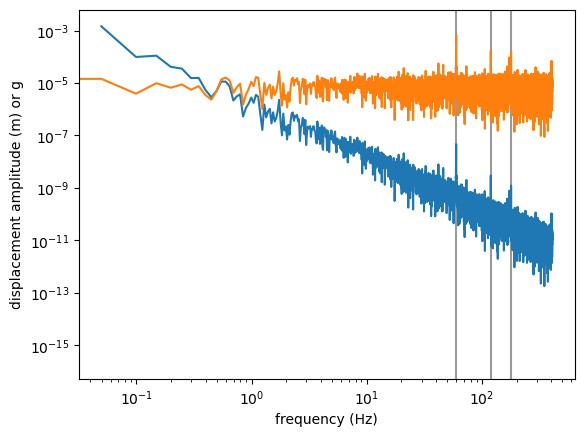

In [711]:
# determine displacement at each amplitude
A_ms2 = A_signal_g * 9.81 #convert g to m/s^2
w = positive_freqs * np.pi * 2
A_displacement = A_ms2[1:] / w[1:]**2
plt.xscale('log')
plt.yscale('log')
plt.ylabel("displacement amplitude (m) or g")
plt.xlabel("frequency (Hz)")
plt.axvline(60, c='k', label='60Hz', alpha=0.4)
plt.axvline(120, c='k', label='120Hz', alpha=0.4)
plt.axvline(180, c='k', label='180Hz', alpha=0.4)
#plt.xlim(1)
plt.plot(positive_freqs[1:], A_displacement)
plt.plot(positive_freqs, A_signal_g)
#plt.ylim(1.e-6,1.e-3)
plt.show()

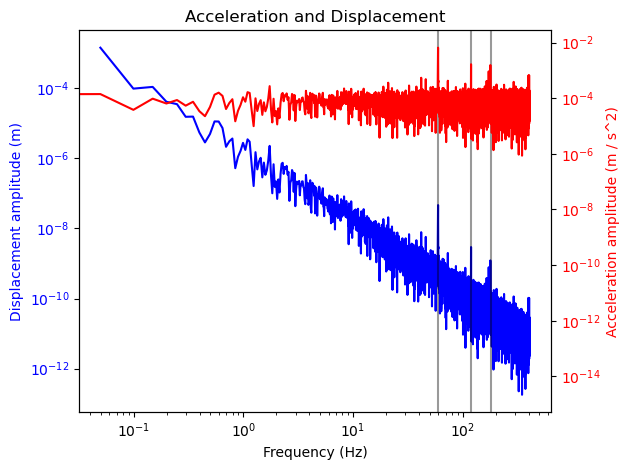

In [745]:
# Assume A_signal_g and positive_freqs are already defined
A_ms2 = A_signal_g * 9.81  # convert g to m/s^2
w = positive_freqs * np.pi * 2
A_displacement = A_ms2[1:] / w[1:]**2

# Create the figure and the first axis (for displacement)
fig, ax1 = plt.subplots()

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Displacement amplitude (m)", color='b')
ax1.plot(positive_freqs[1:], A_displacement, 'b-', label='Displacement')
ax1.tick_params(axis='y', labelcolor='b')

# Add vertical lines on ax1
for f in [60, 120, 180]:
    ax1.axvline(f, c='k', alpha=0.4)

# Create second y-axis for acceleration in g
ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel("Acceleration amplitude (m / s^2)", color='r')
ax2.plot(positive_freqs, A_ms2, 'r', label='Acceleration (m / s^2)')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Acceleration and Displacement")
plt.tight_layout()
plt.show()


In [713]:
def shuyu_fft(data, bin_size, freq):
    """
    data = data
    bin_size = integer number of data points to bin and FFT together
    freq = sampling freq
    """
    
    num_bins = int(len(data)/bin_size)
        
    fft_average = np.zeros(bin_size // 2)
    fft_ = np.zeros((num_bins, bin_size // 2))
    
    fft_freq = np.fft.fftfreq(bin_size, d=1/freq)[:bin_size // 2]
    
    for i in range(num_bins):
        data_bin = data[i*bin_size : (i + 1)*bin_size]
        
        fft_bin = np.fft.fft(data_bin)[:bin_size // 2]
        
        fft_[i] = (2 / bin_size) * np.abs(fft_bin)
        
        fft_average += fft_[i]
    
    fft_average = fft_average / num_bins
    
    return fft_, fft_average, fft_freq, num_bins 

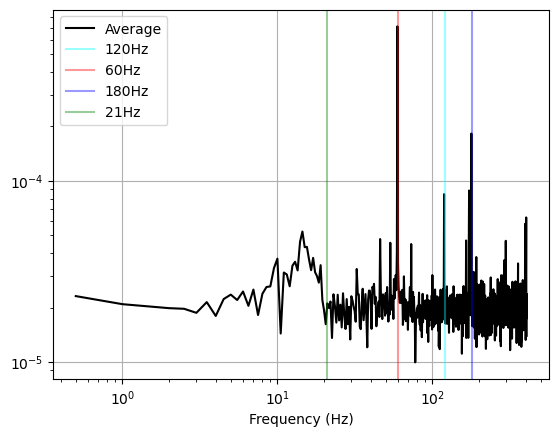

0.0007139437754282632


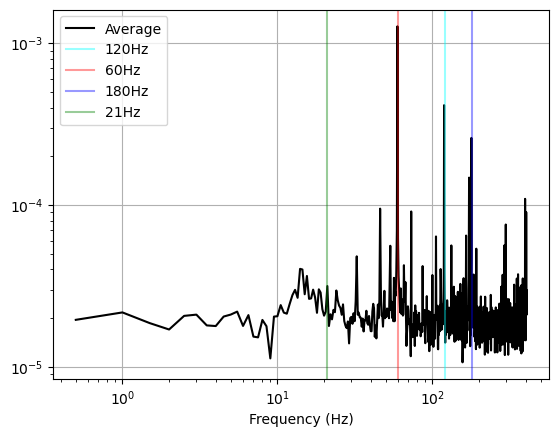

0.0012705429510958203


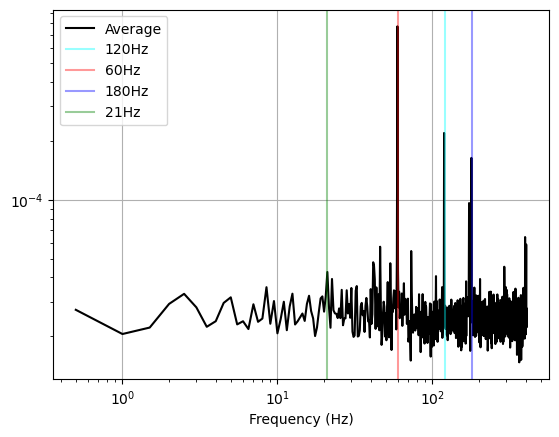

0.0007708530416703099


In [714]:
for data_ch in accel(data_ch0), accel(data_ch1), accel(data_ch2):
    fft_ch, fft_average_ch, fft_freq_ch, num_bins_ch = shuyu_fft(data_ch, int(813.35*2), 813.35)
    valid_indices = fft_freq_ch > 0
    plt.plot(fft_freq_ch[valid_indices], abs(fft_average_ch[valid_indices]), color='black', label='Average')
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    #plt.xlim(98,100)
    plt.axvline(120, c='cyan', label='120Hz', alpha=0.4)
    plt.axvline(60, c='red', label='60Hz', alpha=0.4)
    plt.axvline(180, c='blue', label='180Hz', alpha=0.4)
    plt.axvline(21, c='green', label='21Hz', alpha=0.4)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    print(max(abs(fft_average_ch[valid_indices])))

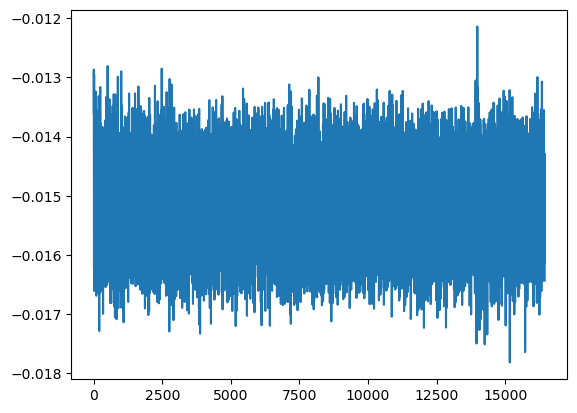

In [715]:
plt.plot(accel(data_ch0))

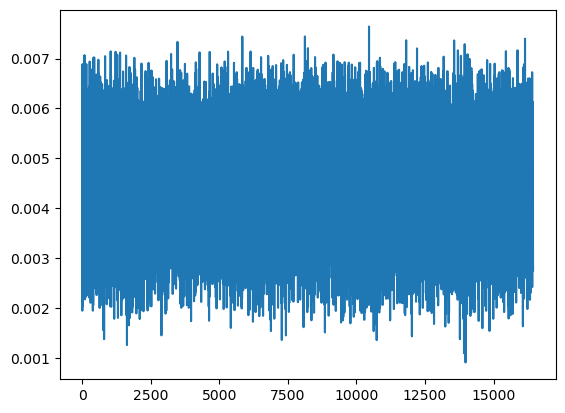

In [716]:
plt.plot(accel(data_ch1))

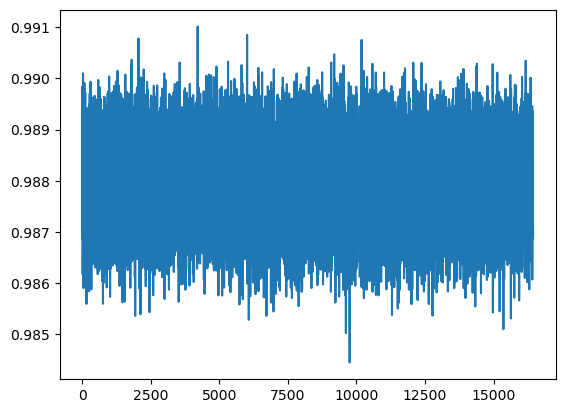

In [717]:
plt.plot(accel(data_ch2))

5.048679160057598
16440


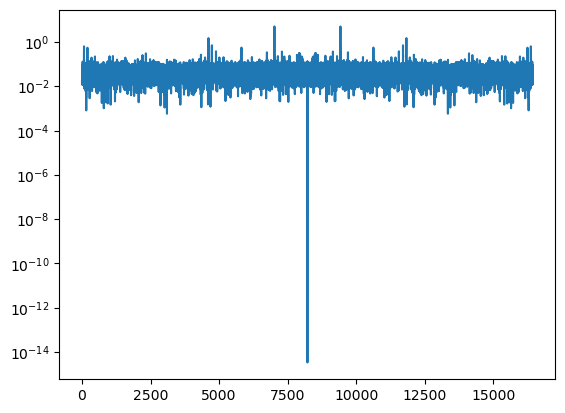

In [718]:
data_ch = data_ch0
fft_accel = np.abs(np.fft.fft(accel(data_ch) - accel(data_ch).mean()))
plt.plot(np.fft.fftshift(fft_accel))
plt.yscale('log')

In [720]:
A_fft = np.max(fft_accel)
N = len(data_ch)
A_sin = A_fft / (N / 2)

# sin wave with amplitude from accelerometer
A_sin_ms2 = A_sin * 9.81 # get amplitude in m/s^2

0.0006141945450191726
